In [1]:
# ============================================
# HOUSE PRICE PREDICTION – END-TO-END PROJECT
# ============================================

# Install extra libs if needed
!pip install seaborn xgboost -q

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# For nicer plots
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# =========================
# 1. LOAD & INSPECT DATA
# =========================

data = fetch_california_housing(as_frame=True)
df = data.frame.copy()

print("Shape:", df.shape)
df.head()


Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [2]:
# Basic info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


In [4]:
df.isna().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


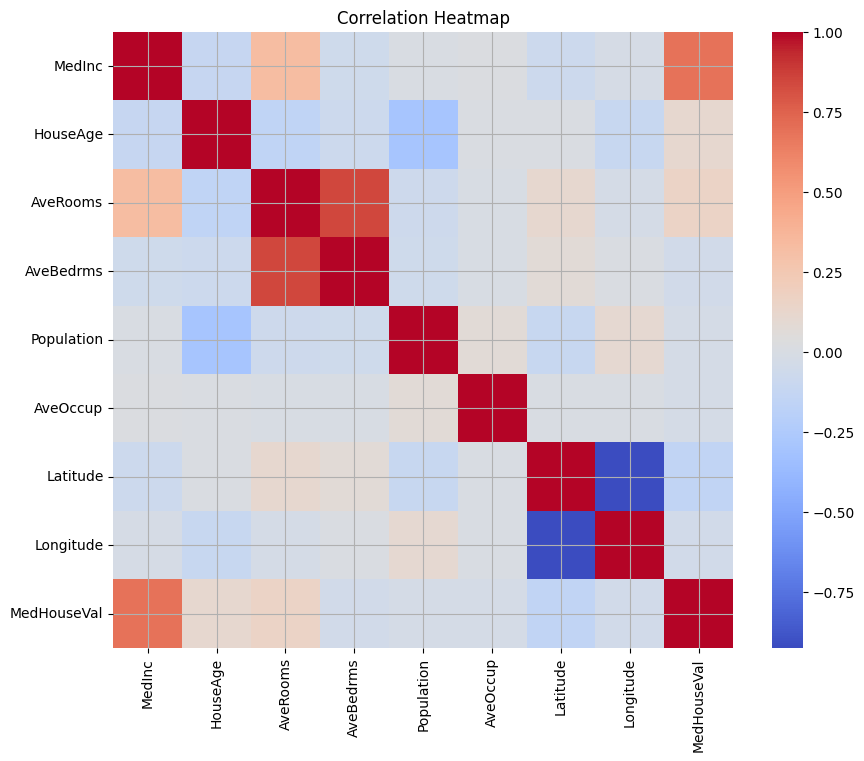

In [5]:
# =========================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# =========================

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


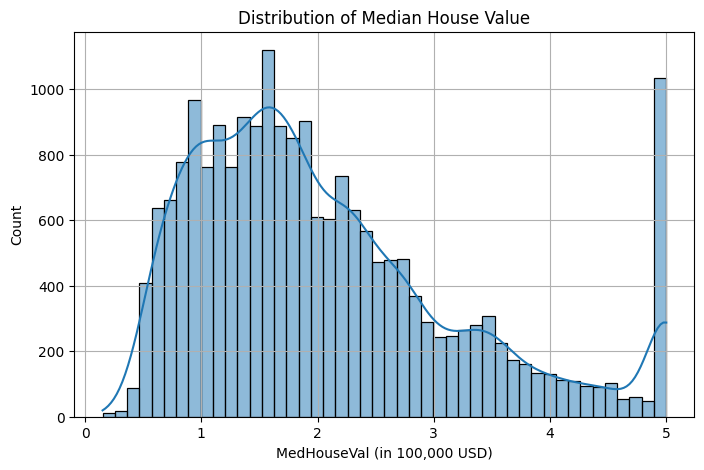

In [6]:
# Target distribution
sns.histplot(df["MedHouseVal"], kde=True)
plt.title("Distribution of Median House Value")
plt.xlabel("MedHouseVal (in 100,000 USD)")
plt.show()


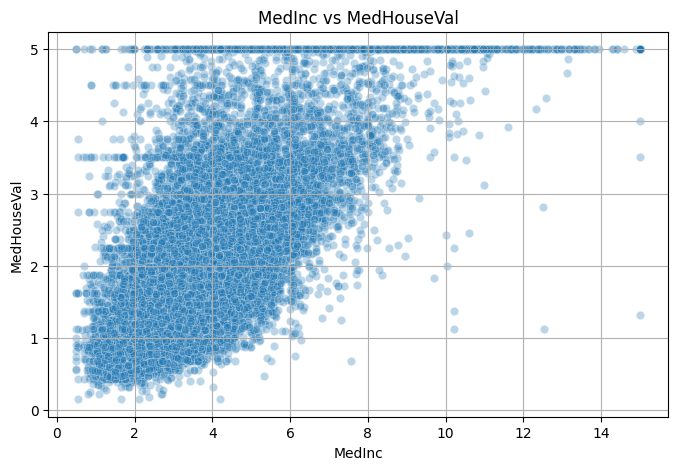

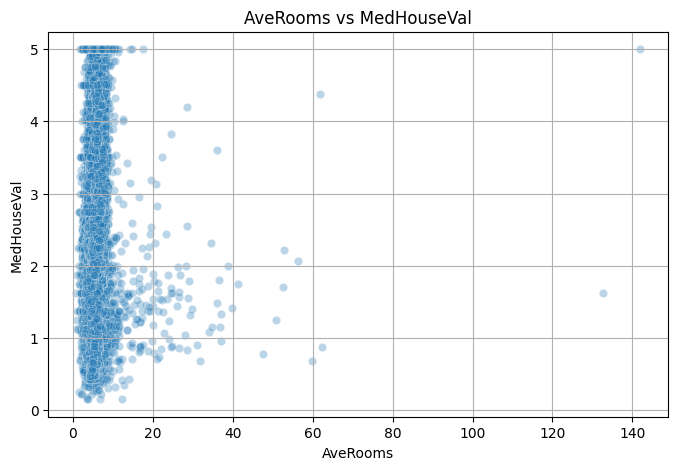

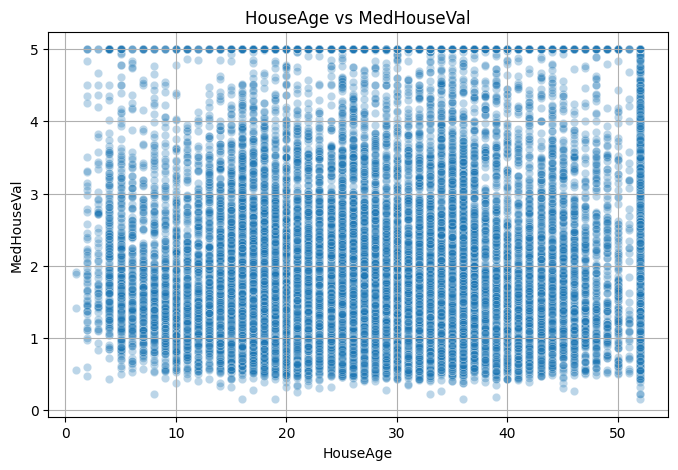

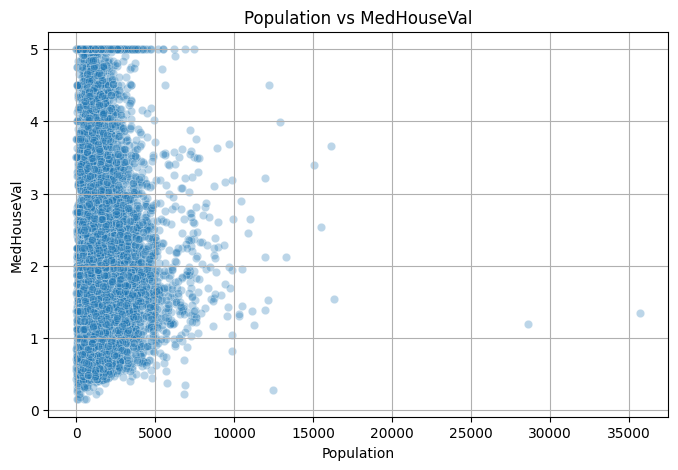

In [7]:
# Relationship with a few key features
for col in ["MedInc", "AveRooms", "HouseAge", "Population"]:
    sns.scatterplot(x=df[col], y=df["MedHouseVal"], alpha=0.3)
    plt.title(f"{col} vs MedHouseVal")
    plt.show()


In [8]:
# =========================
# 3. TRAIN–TEST SPLIT
# =========================

X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((16512, 8), (4128, 8))

In [11]:
# =========================
# 4. SCALING (for linear models)
# =========================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# =========================
# 5. BASELINE MODEL – LINEAR REGRESSION
# =========================

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred_lin = lin_reg.predict(X_test_scaled)

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

results = []
results.append(evaluate_model("Linear Regression", y_test, y_pred_lin))
results


[{'Model': 'Linear Regression',
  'MAE': 0.5332001304956565,
  'RMSE': np.float64(0.7455813830127763),
  'R2': 0.575787706032451}]

In [13]:
# =========================
# 6. REGULARIZED LINEAR MODELS – RIDGE & LASSO
# =========================

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
results.append(evaluate_model("Ridge Regression", y_test, y_pred_ridge))

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)
results.append(evaluate_model("Lasso Regression", y_test, y_pred_lasso))


In [14]:
# =========================
# 7. TREE-BASED MODELS – RF, GBOOST, XGBOOST
# =========================

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append(evaluate_model("Random Forest", y_test, y_pred_rf))

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
results.append(evaluate_model("Gradient Boosting", y_test, y_pred_gbr))

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    objective="reg:squarederror",
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results.append(evaluate_model("XGBoost", y_test, y_pred_xgb))


In [15]:
# =========================
# 8. MODEL COMPARISON TABLE
# =========================

results_df = pd.DataFrame(results)
results_df.sort_values(by="RMSE", ascending=True)


,Model,MAE,RMSE,R2
5,XGBoost,0.330996,0.491264,0.815828
3,Random Forest,0.326812,0.503960,0.806186
4,Gradient Boosting,0.354995,0.521478,0.792477
2,Lasso Regression,0.533145,0.744642,0.576856
1,Ridge Regression,0.533193,0.745557,0.575816
0,Linear Regression,0.533200,0.745581,0.575788


In [16]:
# =========================
# 9. HYPERPARAMETER TUNING – RANDOM FOREST
# =========================

param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt"]
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=5,       # ↓ from 15 to 5
    cv=2,           # ↓ from 3 to 2
    scoring="neg_root_mean_squared_error",
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)
print("Best CV score (neg RMSE):", random_search.best_score_)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Best CV score (neg RMSE): -0.5252775008041435


In [17]:
# Retrain RF with best params
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

best_rf_result = evaluate_model("Random Forest (Tuned)", y_test, y_pred_best_rf)
best_rf_result


{'Model': 'Random Forest (Tuned)',
 'MAE': 0.33807772420442006,
 'RMSE': np.float64(0.5068672344597445),
 'R2': 0.8039433507898024}

In [18]:
# Add tuned RF to comparison
results_df = pd.concat(
    [results_df, pd.DataFrame([best_rf_result])],
    ignore_index=True
)
results_df.sort_values(by="RMSE", ascending=True)


,Model,MAE,RMSE,R2
5,XGBoost,0.330996,0.491264,0.815828
3,Random Forest,0.326812,0.503960,0.806186
6,Random Forest (Tuned),0.338078,0.506867,0.803943
4,Gradient Boosting,0.354995,0.521478,0.792477
2,Lasso Regression,0.533145,0.744642,0.576856
1,Ridge Regression,0.533193,0.745557,0.575816
0,Linear Regression,0.533200,0.745581,0.575788


In [19]:
# =========================
# 10. CROSS-VALIDATION ON BEST MODEL
# =========================

cv_scores = cross_val_score(
    best_rf,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

print("CV RMSE scores:", -cv_scores)
print("Mean CV RMSE:", -cv_scores.mean())


CV RMSE scores: [0.70204151 0.58217248 0.62986853 0.69162453 0.75654988]
Mean CV RMSE: 0.6724513850542184


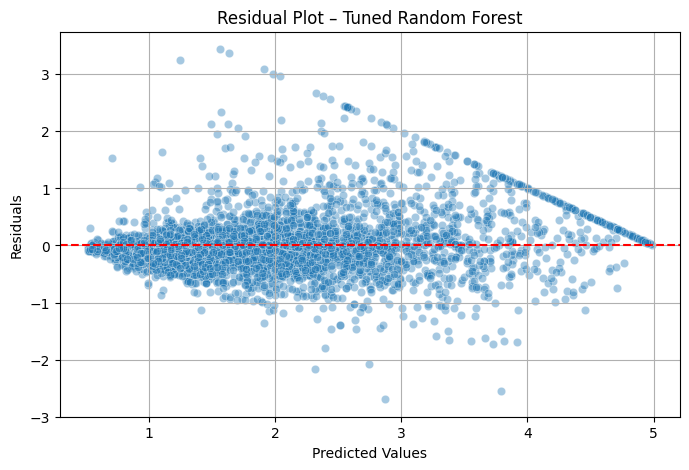

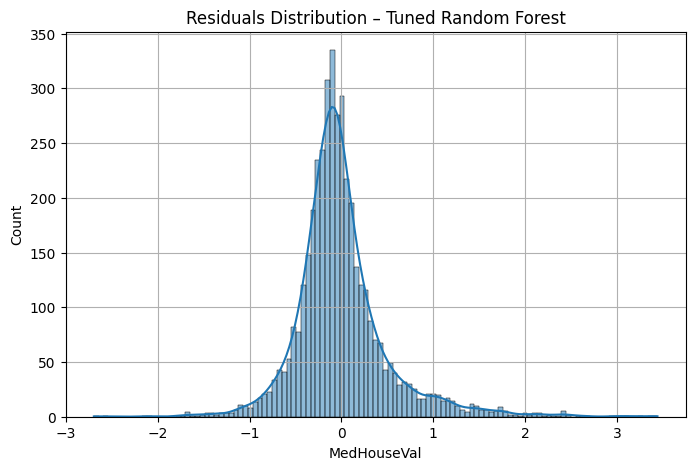

In [20]:
# =========================
# 11. RESIDUAL ANALYSIS (BEST MODEL)
# =========================

residuals = y_test - y_pred_best_rf

sns.scatterplot(x=y_pred_best_rf, y=residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot – Tuned Random Forest")
plt.show()

sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution – Tuned Random Forest")
plt.show()


In [21]:
# =========================
# 12. FEATURE IMPORTANCE (BEST MODEL – TREE BASED)
# =========================

feature_importances = pd.DataFrame({
    "feature": X.columns,
    "importance": best_rf.feature_importances_
}).sort_values("importance", ascending=False)

feature_importances


,feature,importance
0,MedInc,0.384385
6,Latitude,0.134670
7,Longitude,0.133136
5,AveOccup,0.121246
2,AveRooms,0.116917
1,HouseAge,0.051929
3,AveBedrms,0.034371
4,Population,0.023345


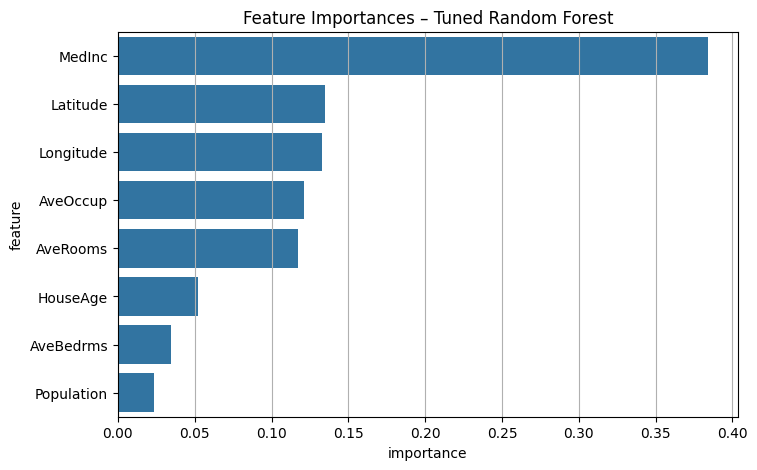

In [22]:
sns.barplot(
    data=feature_importances,
    x="importance",
    y="feature"
)
plt.title("Feature Importances – Tuned Random Forest")
plt.show()


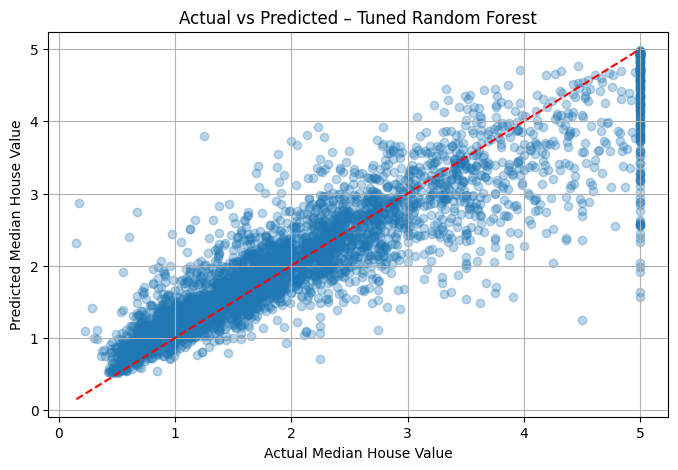

In [23]:
# =========================
# 13. ACTUAL VS PREDICTED PLOT (BEST MODEL)
# =========================

plt.scatter(y_test, y_pred_best_rf, alpha=0.3)
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Actual vs Predicted – Tuned Random Forest")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.show()


In [24]:
# =========================
# 14. PREPARE DATA FOR POWER BI
# =========================

# Create a DataFrame with:
# - Original features
# - Actual price
# - Predicted price (best model)
# - Residuals

X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

powerbi_df = X_test_reset.copy()
powerbi_df["Actual_MedHouseVal"] = y_test_reset
powerbi_df["Predicted_MedHouseVal"] = y_pred_best_rf
powerbi_df["Residual"] = powerbi_df["Actual_MedHouseVal"] - powerbi_df["Predicted_MedHouseVal"]

powerbi_df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Actual_MedHouseVal,Predicted_MedHouseVal,Residual
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,0.47700,0.526243,-0.049243
1,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46,0.45800,0.949111,-0.491111
2,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44,5.00001,4.680402,0.319608
3,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72,2.18600,2.542637,-0.356637
4,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93,2.78000,2.287585,0.492415


In [25]:
# Save file for Power BI
powerbi_df.to_csv("house_price_predictions_powerbi.csv", index=False)
print("Exported: house_price_predictions_powerbi.csv")


Exported: house_price_predictions_powerbi.csv
